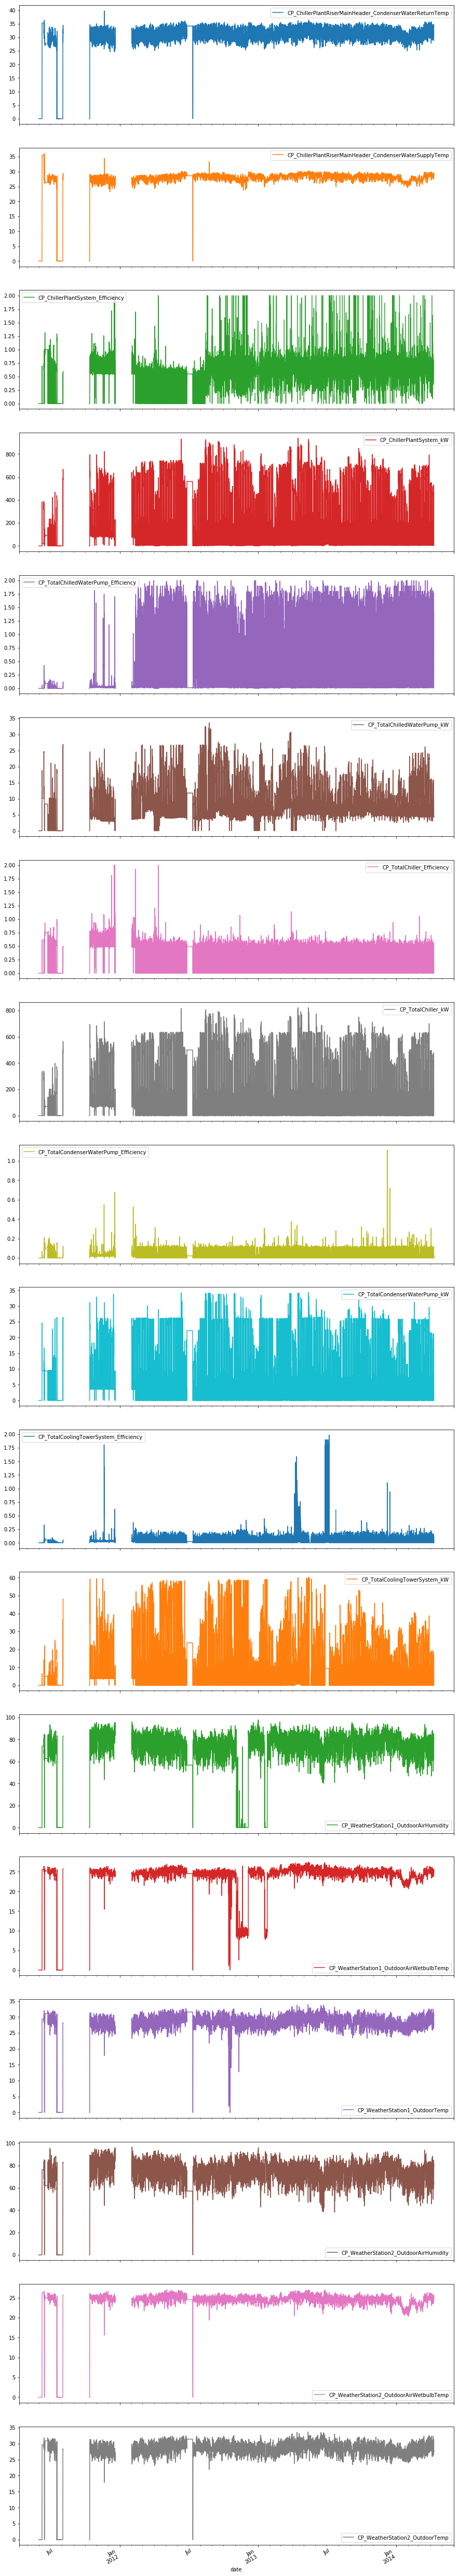

In [46]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import json
from sklearn import preprocessing
from sklearn.cluster import KMeans
from operator import itemgetter
import seaborn as sns

### read and drop the last column
cp_sys = pd.read_csv("./../FullRawChillerPlantSystem.csv", index_col="date", parse_dates=True)
cp_sys.drop('Unnamed: 0', axis=1, inplace=True)
sys_m_std = cp_sys.resample('H').std()
cp_sys = cp_sys.resample('H').mean()
cp_sys.plot(subplots=True, figsize=(15,100))
plt.show()

In [57]:
# add the weekdays and weekends
weekday = pd.DataFrame(list(cp_sys.index.weekday))
weekday = weekday.set_index(cp_sys.index)
cp_sys['weekday'] = weekday
print(weekday)

                     0
date                  
2011-06-01 00:00:00  2
2011-06-01 01:00:00  2
2011-06-01 02:00:00  2
2011-06-01 03:00:00  2
2011-06-01 04:00:00  2
2011-06-01 05:00:00  2
2011-06-01 06:00:00  2
2011-06-01 07:00:00  2
2011-06-01 08:00:00  2
2011-06-01 09:00:00  2
2011-06-01 10:00:00  2
2011-06-01 11:00:00  2
2011-06-01 12:00:00  2
2011-06-01 13:00:00  2
2011-06-01 14:00:00  2
2011-06-01 15:00:00  2
2011-06-01 16:00:00  2
2011-06-01 17:00:00  2
2011-06-01 18:00:00  2
2011-06-01 19:00:00  2
2011-06-01 20:00:00  2
2011-06-01 21:00:00  2
2011-06-01 22:00:00  2
2011-06-01 23:00:00  2
2011-06-02 00:00:00  3
2011-06-02 01:00:00  3
2011-06-02 02:00:00  3
2011-06-02 03:00:00  3
2011-06-02 04:00:00  3
2011-06-02 05:00:00  3
...                 ..
2014-04-07 22:00:00  0
2014-04-08 00:00:00  1
2014-04-08 01:00:00  1
2014-04-08 03:00:00  1
2014-04-08 04:00:00  1
2014-04-08 06:00:00  1
2014-04-08 07:00:00  1
2014-04-08 08:00:00  1
2014-04-08 09:00:00  1
2014-04-08 10:00:00  1
2014-04-08 

In [63]:
#print(sys_m_std['CP_ChillerPlantSystem_kW'])
cp_sys['sys_kw_std'] = sys_m_std['CP_ChillerPlantSystem_kW']
cp_sys.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19201 entries, 2011-06-01 00:00:00 to 2014-04-09 11:00:00
Data columns (total 20 columns):
CP_ChillerPlantRiserMainHeader_CondenserWaterReturnTemp    19201 non-null float64
CP_ChillerPlantRiserMainHeader_CondenserWaterSupplyTemp    19201 non-null float64
CP_ChillerPlantSystem_Efficiency                           19201 non-null float64
CP_ChillerPlantSystem_kW                                   19201 non-null float64
CP_TotalChilledWaterPump_Efficiency                        19201 non-null float64
CP_TotalChilledWaterPump_kW                                19201 non-null float64
CP_TotalChiller_Efficiency                                 19201 non-null float64
CP_TotalChiller_kW                                         19201 non-null float64
CP_TotalCondenserWaterPump_Efficiency                      19201 non-null float64
CP_TotalCondenserWaterPump_kW                              19201 non-null float64
CP_TotalCoolingTowerSystem_Efficienc

In [49]:
### drop the lines that contains nan
cp_sys = cp_sys.dropna(axis=0)
cp_sys.info()
weekday_final = cp_sys['weekday']

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19201 entries, 2011-06-01 00:00:00 to 2014-04-09 11:00:00
Data columns (total 20 columns):
CP_ChillerPlantRiserMainHeader_CondenserWaterReturnTemp    19201 non-null float64
CP_ChillerPlantRiserMainHeader_CondenserWaterSupplyTemp    19201 non-null float64
CP_ChillerPlantSystem_Efficiency                           19201 non-null float64
CP_ChillerPlantSystem_kW                                   19201 non-null float64
CP_TotalChilledWaterPump_Efficiency                        19201 non-null float64
CP_TotalChilledWaterPump_kW                                19201 non-null float64
CP_TotalChiller_Efficiency                                 19201 non-null float64
CP_TotalChiller_kW                                         19201 non-null float64
CP_TotalCondenserWaterPump_Efficiency                      19201 non-null float64
CP_TotalCondenserWaterPump_kW                              19201 non-null float64
CP_TotalCoolingTowerSystem_Efficienc

In [59]:
### drop the numbers that has 3 standard deviation from the mean
#CP_ChillerPlantRiserMainHeader_CondenserWaterReturnTemp 
conden_ret_tmp = cp_sys['CP_ChillerPlantRiserMainHeader_CondenserWaterReturnTemp']
conden_ret_tmp_clean = conden_ret_tmp[(conden_ret_tmp<(conden_ret_tmp.mean()+3*conden_ret_tmp.std())) 
                                      & (conden_ret_tmp>(conden_ret_tmp.mean()-3*conden_ret_tmp.std()))]
#CP_ChillerPlantRiserMainHeader_CondenserWaterSupplyTemp 
conden_sup_tmp = cp_sys['CP_ChillerPlantRiserMainHeader_CondenserWaterSupplyTemp']
conden_sup_tmp_clean = conden_sup_tmp[(conden_sup_tmp<(conden_sup_tmp.mean()+3*conden_sup_tmp.std()))
                                     & (conden_sup_tmp>(conden_sup_tmp.mean()-3*conden_sup_tmp.std()))]
#CP_WeatherStation1_OutdoorAirHumidity
sta1_air_hum = cp_sys['CP_WeatherStation1_OutdoorAirHumidity']
sta1_air_hum_clean = sta1_air_hum[(sta1_air_hum<(sta1_air_hum.mean()+3*sta1_air_hum.std()))
                                 & (sta1_air_hum>(sta1_air_hum.mean()-3*sta1_air_hum.std()))]
#CP_WeatherStation1_OutdoorAirWetbulbTemp  
sta1_air_wetemp = cp_sys['CP_WeatherStation1_OutdoorAirWetbulbTemp']
sta1_air_wetemp_clean = sta1_air_wetemp[(sta1_air_wetemp<(sta1_air_wetemp.mean()+3*sta1_air_wetemp.std()))
                                       & (sta1_air_wetemp>(sta1_air_wetemp.mean()-3*sta1_air_wetemp.std()))]
#CP_WeatherStation1_OutdoorTemp
sta1_air_outmp = cp_sys['CP_WeatherStation1_OutdoorTemp']
sta1_air_outmp_clean = sta1_air_outmp[(sta1_air_outmp<(sta1_air_outmp.mean()+3*sta1_air_outmp.std()))
                                     & (sta1_air_outmp>(sta1_air_outmp.mean()-3*sta1_air_outmp.std()))]
#CP_WeatherStation2_OutdoorAirHumidity 
sta2_air_hum = cp_sys['CP_WeatherStation2_OutdoorAirHumidity']
sta2_air_hum_clean = sta2_air_hum[(sta2_air_hum<(sta2_air_hum.mean()+3*sta2_air_hum.std()))
                                 & (sta2_air_hum>(sta2_air_hum.mean()-3*sta2_air_hum.std()))]
#CP_WeatherStation2_OutdoorAirWetbulbTemp  
sta2_air_wetemp = cp_sys['CP_WeatherStation2_OutdoorAirWetbulbTemp']
sta2_air_wetemp_clean = sta2_air_wetemp[(sta2_air_wetemp<(sta2_air_wetemp.mean()+3*sta2_air_wetemp.std()))
                                       & (sta2_air_wetemp>(sta2_air_wetemp.mean()-3*sta2_air_wetemp.std()))]
#CP_WeatherStation2_OutdoorTemp
sta2_air_outmp = cp_sys['CP_WeatherStation2_OutdoorTemp']
sta2_air_outmp_clean = sta2_air_outmp[(sta2_air_outmp<(sta2_air_outmp.mean()+3*sta2_air_outmp.std()))
                                     & (sta2_air_outmp>(sta2_air_outmp.mean()-3*sta2_air_outmp.std()))]
#std
sys_kw_std = cp_sys['sys_kw_std']
sys_kw_std_clean = sys_kw_std[(sys_kw_std<(sys_kw_std.mean()+3*sys_kw_std.std()))
                                     & (sys_kw_std>(sys_kw_std.mean()-3*sys_kw_std.std()))]

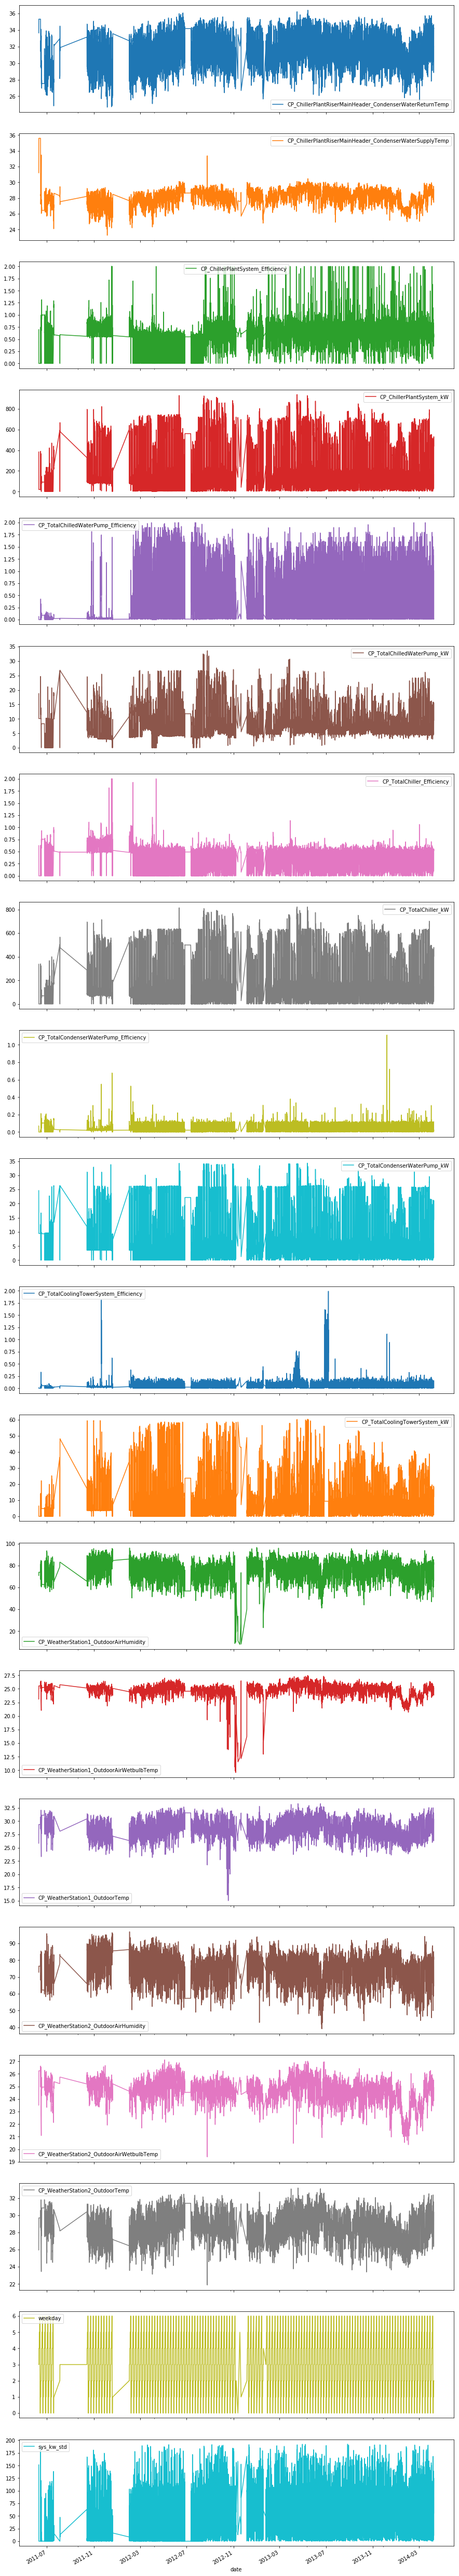

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17711 entries, 2011-06-09 16:00:00 to 2014-04-09 11:00:00
Data columns (total 20 columns):
CP_ChillerPlantRiserMainHeader_CondenserWaterReturnTemp    17711 non-null float64
CP_ChillerPlantRiserMainHeader_CondenserWaterSupplyTemp    17711 non-null float64
CP_ChillerPlantSystem_Efficiency                           17711 non-null float64
CP_ChillerPlantSystem_kW                                   17711 non-null float64
CP_TotalChilledWaterPump_Efficiency                        17711 non-null float64
CP_TotalChilledWaterPump_kW                                17711 non-null float64
CP_TotalChiller_Efficiency                                 17711 non-null float64
CP_TotalChiller_kW                                         17711 non-null float64
CP_TotalCondenserWaterPump_Efficiency                      17711 non-null float64
CP_TotalCondenserWaterPump_kW                              17711 non-null float64
CP_TotalCoolingTowerSystem_Efficienc

In [66]:
### create a new dataframe with the new series
CP_ChillerPlantRiserMainHeader_CondenserWaterReturnTemp = pd.DataFrame(conden_ret_tmp_clean)
CP_ChillerPlantRiserMainHeader_CondenserWaterSupplyTemp = pd.DataFrame(conden_sup_tmp_clean)
CP_ChillerPlantSystem_Efficiency = pd.DataFrame(cp_sys['CP_ChillerPlantSystem_Efficiency'])
CP_ChillerPlantSystem_kW = pd.DataFrame(cp_sys['CP_ChillerPlantSystem_kW'])
CP_TotalChilledWaterPump_Efficiency = pd.DataFrame(cp_sys['CP_TotalChilledWaterPump_Efficiency'])
CP_TotalChilledWaterPump_kW = pd.DataFrame(cp_sys['CP_TotalChilledWaterPump_kW'])
CP_TotalChiller_Efficiency = pd.DataFrame(cp_sys['CP_TotalChiller_Efficiency'])
CP_TotalChiller_kW = pd.DataFrame(cp_sys['CP_TotalChiller_kW'])
CP_TotalCondenserWaterPump_Efficiency = pd.DataFrame(cp_sys['CP_TotalCondenserWaterPump_Efficiency'])
CP_TotalCondenserWaterPump_kW = pd.DataFrame(cp_sys['CP_TotalCondenserWaterPump_kW'])
CP_TotalCoolingTowerSystem_Efficiency = pd.DataFrame(cp_sys['CP_TotalCoolingTowerSystem_Efficiency'])
CP_TotalCoolingTowerSystem_kW = pd.DataFrame(cp_sys['CP_TotalCoolingTowerSystem_kW'])
CP_WeatherStation1_OutdoorAirHumidity = pd.DataFrame(sta1_air_hum_clean)
CP_WeatherStation1_OutdoorAirWetbulbTemp = pd.DataFrame(sta1_air_wetemp_clean)
CP_WeatherStation1_OutdoorTemp = pd.DataFrame(sta1_air_outmp_clean)
CP_WeatherStation2_OutdoorAirHumidity = pd.DataFrame(sta2_air_hum_clean)
CP_WeatherStation2_OutdoorAirWetbulbTemp = pd.DataFrame(sta2_air_wetemp_clean)
CP_WeatherStation2_OutdoorTemp = pd.DataFrame(sta2_air_outmp_clean)
sys_kw_std_new = pd.DataFrame(sys_kw_std_clean)
cp_sys_clean = pd.concat([CP_ChillerPlantRiserMainHeader_CondenserWaterReturnTemp,
                   CP_ChillerPlantRiserMainHeader_CondenserWaterSupplyTemp,
                   CP_ChillerPlantSystem_Efficiency,
                   CP_ChillerPlantSystem_kW,
                   CP_TotalChilledWaterPump_Efficiency,
                   CP_TotalChilledWaterPump_kW,
                   CP_TotalChiller_Efficiency,
                   CP_TotalChiller_kW,
                   CP_TotalCondenserWaterPump_Efficiency,
                   CP_TotalCondenserWaterPump_kW,
                   CP_TotalCoolingTowerSystem_Efficiency,
                   CP_TotalCoolingTowerSystem_kW,
                   CP_WeatherStation1_OutdoorAirHumidity,
                   CP_WeatherStation1_OutdoorAirWetbulbTemp,
                   CP_WeatherStation1_OutdoorTemp,
                   CP_WeatherStation2_OutdoorAirHumidity,
                   CP_WeatherStation2_OutdoorAirWetbulbTemp,
                   CP_WeatherStation2_OutdoorTemp,
                   weekday_final,
                   sys_kw_std_new],axis=1).dropna(axis=0)
cp_sys_clean.plot(subplots=True,figsize=(15,100))
plt.show()
cp_sys_clean.info()
weekday_final = cp_sys_clean['weekday']

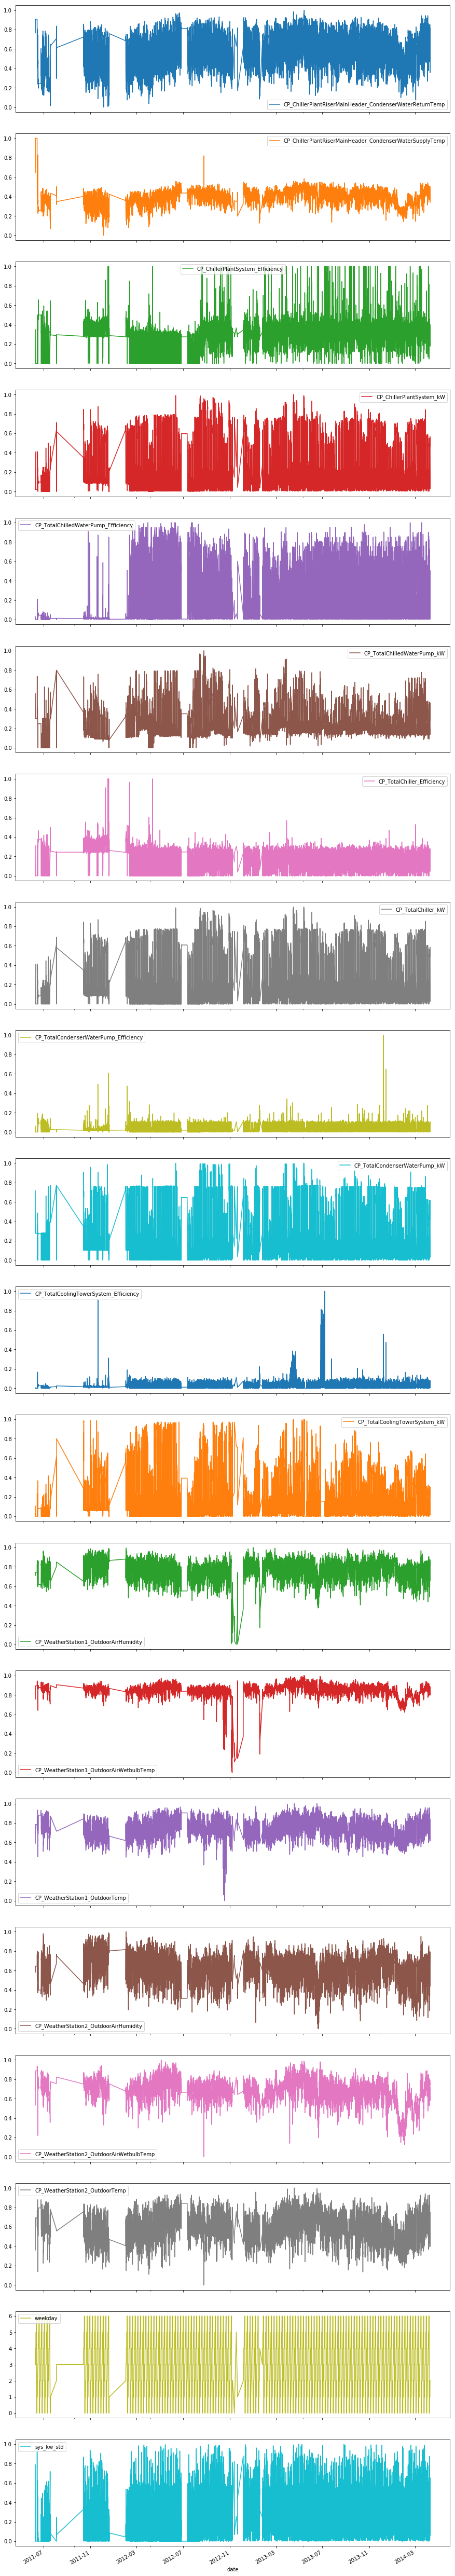

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17711 entries, 2011-06-09 16:00:00 to 2014-04-09 11:00:00
Data columns (total 20 columns):
CP_ChillerPlantRiserMainHeader_CondenserWaterReturnTemp    17711 non-null float64
CP_ChillerPlantRiserMainHeader_CondenserWaterSupplyTemp    17711 non-null float64
CP_ChillerPlantSystem_Efficiency                           17711 non-null float64
CP_ChillerPlantSystem_kW                                   17711 non-null float64
CP_TotalChilledWaterPump_Efficiency                        17711 non-null float64
CP_TotalChilledWaterPump_kW                                17711 non-null float64
CP_TotalChiller_Efficiency                                 17711 non-null float64
CP_TotalChiller_kW                                         17711 non-null float64
CP_TotalCondenserWaterPump_Efficiency                      17711 non-null float64
CP_TotalCondenserWaterPump_kW                              17711 non-null float64
CP_TotalCoolingTowerSystem_Efficienc

In [67]:
### scale the data into [0,1]
min_max_scaler = preprocessing.MinMaxScaler()
s_con_ret_tmp = pd.DataFrame(min_max_scaler.fit_transform(cp_sys_clean["CP_ChillerPlantRiserMainHeader_CondenserWaterReturnTemp"].values.reshape(-1,1)),
                            columns=["CP_ChillerPlantRiserMainHeader_CondenserWaterReturnTemp"],
                            index=cp_sys_clean.index)
s_con_sup_tmp = pd.DataFrame(min_max_scaler.fit_transform(cp_sys_clean["CP_ChillerPlantRiserMainHeader_CondenserWaterSupplyTemp"].values.reshape(-1,1)),
                            columns=["CP_ChillerPlantRiserMainHeader_CondenserWaterSupplyTemp"],
                            index=cp_sys_clean.index)
s_ch_sys_eff = pd.DataFrame(min_max_scaler.fit_transform(cp_sys_clean["CP_ChillerPlantSystem_Efficiency"].values.reshape(-1,1)),
                            columns=["CP_ChillerPlantSystem_Efficiency"],
                            index=cp_sys_clean.index)
s_ch_sys_kw = pd.DataFrame(min_max_scaler.fit_transform(cp_sys_clean["CP_ChillerPlantSystem_kW"].values.reshape(-1,1)),
                            columns=["CP_ChillerPlantSystem_kW"],
                            index=cp_sys_clean.index)
s_ch_pump_eff = pd.DataFrame(min_max_scaler.fit_transform(cp_sys_clean["CP_TotalChilledWaterPump_Efficiency"].values.reshape(-1,1)),
                            columns=["CP_TotalChilledWaterPump_Efficiency"],
                            index=cp_sys_clean.index)
s_ch_pump_kw = pd.DataFrame(min_max_scaler.fit_transform(cp_sys_clean["CP_TotalChilledWaterPump_kW"].values.reshape(-1,1)),
                            columns=["CP_TotalChilledWaterPump_kW"],
                            index=cp_sys_clean.index)
s_tot_chi_eff = pd.DataFrame(min_max_scaler.fit_transform(cp_sys_clean["CP_TotalChiller_Efficiency"].values.reshape(-1,1)),
                            columns=["CP_TotalChiller_Efficiency"],
                            index=cp_sys_clean.index)
s_tot_chi_kw = pd.DataFrame(min_max_scaler.fit_transform(cp_sys_clean["CP_TotalChiller_kW"].values.reshape(-1,1)),
                            columns=["CP_TotalChiller_kW"],
                            index=cp_sys_clean.index)
s_con_pump_eff = pd.DataFrame(min_max_scaler.fit_transform(cp_sys_clean["CP_TotalCondenserWaterPump_Efficiency"].values.reshape(-1,1)),
                            columns=["CP_TotalCondenserWaterPump_Efficiency"],
                            index=cp_sys_clean.index)
s_con_pump_kw = pd.DataFrame(min_max_scaler.fit_transform(cp_sys_clean["CP_TotalCondenserWaterPump_kW"].values.reshape(-1,1)),
                            columns=["CP_TotalCondenserWaterPump_kW"],
                            index=cp_sys_clean.index)
s_tow_sys_eff = pd.DataFrame(min_max_scaler.fit_transform(cp_sys_clean["CP_TotalCoolingTowerSystem_Efficiency"].values.reshape(-1,1)),
                            columns=["CP_TotalCoolingTowerSystem_Efficiency"],
                            index=cp_sys_clean.index)
s_tow_sys_kw = pd.DataFrame(min_max_scaler.fit_transform(cp_sys_clean["CP_TotalCoolingTowerSystem_kW"].values.reshape(-1,1)),
                            columns=["CP_TotalCoolingTowerSystem_kW"],
                            index=cp_sys_clean.index)
s_stat1_air_hum = pd.DataFrame(min_max_scaler.fit_transform(cp_sys_clean["CP_WeatherStation1_OutdoorAirHumidity"].values.reshape(-1,1)),
                            columns=["CP_WeatherStation1_OutdoorAirHumidity"],
                            index=cp_sys_clean.index)
s_stat1_wet_tmp = pd.DataFrame(min_max_scaler.fit_transform(cp_sys_clean["CP_WeatherStation1_OutdoorAirWetbulbTemp"].values.reshape(-1,1)),
                            columns=["CP_WeatherStation1_OutdoorAirWetbulbTemp"],
                            index=cp_sys_clean.index)
s_stat1_out_tmp = pd.DataFrame(min_max_scaler.fit_transform(cp_sys_clean["CP_WeatherStation1_OutdoorTemp"].values.reshape(-1,1)),
                            columns=["CP_WeatherStation1_OutdoorTemp"],
                            index=cp_sys_clean.index)
s_stat2_air_hum = pd.DataFrame(min_max_scaler.fit_transform(cp_sys_clean["CP_WeatherStation2_OutdoorAirHumidity"].values.reshape(-1,1)),
                            columns=["CP_WeatherStation2_OutdoorAirHumidity"],
                            index=cp_sys_clean.index)
s_stat2_wet_tmp = pd.DataFrame(min_max_scaler.fit_transform(cp_sys_clean["CP_WeatherStation2_OutdoorAirWetbulbTemp"].values.reshape(-1,1)),
                            columns=["CP_WeatherStation2_OutdoorAirWetbulbTemp"],
                            index=cp_sys_clean.index)
s_stat2_out_tmp = pd.DataFrame(min_max_scaler.fit_transform(cp_sys_clean["CP_WeatherStation2_OutdoorTemp"].values.reshape(-1,1)),
                            columns=["CP_WeatherStation2_OutdoorTemp"],
                            index=cp_sys_clean.index)
s_sys_kw_std = pd.DataFrame(min_max_scaler.fit_transform(cp_sys_clean["sys_kw_std"].values.reshape(-1,1)),
                            columns=["sys_kw_std"],
                            index=cp_sys_clean.index)
s_cp_sys_clean = pd.concat([s_con_ret_tmp,
                           s_con_sup_tmp,
                           s_ch_sys_eff,
                           s_ch_sys_kw,
                           s_ch_pump_eff,
                           s_ch_pump_kw,
                           s_tot_chi_eff,
                           s_tot_chi_kw,
                           s_con_pump_eff,
                           s_con_pump_kw,
                           s_tow_sys_eff,
                           s_tow_sys_kw,
                           s_stat1_air_hum,
                           s_stat1_wet_tmp,
                           s_stat1_out_tmp,
                           s_stat2_air_hum,
                           s_stat2_wet_tmp,
                           s_stat2_out_tmp,
                           weekday_final,
                           s_sys_kw_std],axis=1)
s_cp_sys_clean.plot(subplots=True,figsize=(15,100))
plt.show()
s_cp_sys_clean.info()

In [68]:
print(s_cp_sys_clean)

                     CP_ChillerPlantRiserMainHeader_CondenserWaterReturnTemp  \
date                                                                           
2011-06-09 16:00:00                                           0.765785         
2011-06-09 17:00:00                                           0.907725         
2011-06-09 18:00:00                                           0.907725         
2011-06-09 19:00:00                                           0.907725         
2011-06-09 20:00:00                                           0.907725         
2011-06-09 21:00:00                                           0.907725         
2011-06-09 22:00:00                                           0.907725         
2011-06-09 23:00:00                                           0.907725         
2011-06-10 00:00:00                                           0.907725         
2011-06-10 01:00:00                                           0.907725         
2011-06-10 02:00:00                     

In [80]:
print(s_cp_sys_clean.iloc[2]['weekday'] == 3.0)

True


In [83]:
### define a function to seperate the day and night
def seperatedaynighttime(inputstring):
    if("08:00:00" in inputstring or
       "09:00:00" in inputstring or
       "10:00:00" in inputstring or
       "11:00:00" in inputstring or
       "12:00:00" in inputstring or
       "13:00:00" in inputstring or
       "14:00:00" in inputstring or
       "15:00:00" in inputstring or
       "16:00:00" in inputstring):
        return True
    else:
        return False
### define a funtion to seperate the weekend and weekday
def seperateweekdaytime(i):
    if(s_cp_sys_clean.iloc[i]['weekday'] == 5.0 or
       s_cp_sys_clean.iloc[i]['weekday'] == 6.0):
        ### weekend
        return True
    else:
        ### weekday
        return False
day_weekday_time = []
night_weekday_time = []
day_weekend_time = []
night_weekend_time = []
for i in range(17711):
    if(seperatedaynighttime(str(s_cp_sys_clean.iloc[i]))):
        if(seperateweekdaytime(i)):
            day_weekend_time.append(dict(s_cp_sys_clean.iloc[i]))
        else:
            day_weekday_time.append(dict(s_cp_sys_clean.iloc[i]))
    else:
        if(seperateweekdaytime(i)):
            night_weekend_time.append(dict(s_cp_sys_clean.iloc[i]))
        else:
            night_weekday_time.append(dict(s_cp_sys_clean.iloc[i]))
day_weekend_time_df = pd.DataFrame(day_weekend_time)
day_weekday_time_df = pd.DataFrame(day_weekday_time)
night_weekend_time_df = pd.DataFrame(night_weekend_time)
night_weekday_time_df = pd.DataFrame(night_weekday_time)
day_weekend_time_df.to_csv('day_weekend_time.basket', index=False, header=False, sep= ',')
day_weekday_time_df.to_csv('day_weekday_time.basket', index=False, header=False, sep= ',')
night_weekend_time_df.to_csv('night_weekend_time.basket', index=False, header=False, sep= ',')
night_weekday_time_df.to_csv('night_weekday_time.basket', index=False, header=False, sep= ',')

In [54]:
day_con_ret_tmp = pd.DataFrame(day_time_df["CP_ChillerPlantRiserMainHeader_CondenserWaterReturnTemp"])
day_con_sup_tmp = pd.DataFrame(day_time_df["CP_ChillerPlantRiserMainHeader_CondenserWaterSupplyTemp"])
day_ch_sys_eff = pd.DataFrame(day_time_df["CP_ChillerPlantSystem_Efficiency"])
day_ch_sys_kw = pd.DataFrame(day_time_df["CP_ChillerPlantSystem_kW"])
day_ch_pump_eff = pd.DataFrame(day_time_df["CP_TotalChilledWaterPump_Efficiency"])
day_ch_pump_kw = pd.DataFrame(day_time_df["CP_TotalChilledWaterPump_kW"])
day_tot_chi_eff = pd.DataFrame(day_time_df["CP_TotalChiller_Efficiency"])
day_tot_chi_kw = pd.DataFrame(day_time_df["CP_TotalChiller_kW"])
day_con_pump_eff = pd.DataFrame(day_time_df["CP_TotalCondenserWaterPump_Efficiency"])
day_con_pump_kw = pd.DataFrame(day_time_df["CP_TotalCondenserWaterPump_kW"])
day_tow_sys_eff = pd.DataFrame(day_time_df["CP_TotalCoolingTowerSystem_Efficiency"])
day_tow_sys_kw = pd.DataFrame(day_time_df["CP_TotalCoolingTowerSystem_kW"])
day_stat1_air_hum = pd.DataFrame(day_time_df["CP_WeatherStation1_OutdoorAirHumidity"])
day_stat1_wet_tmp = pd.DataFrame(day_time_df["CP_WeatherStation1_OutdoorAirWetbulbTemp"])
day_stat1_out_tmp = pd.DataFrame(day_time_df["CP_WeatherStation1_OutdoorTemp"])
day_stat2_air_hum = pd.DataFrame(day_time_df["CP_WeatherStation2_OutdoorAirHumidity"])
day_stat2_wet_tmp = pd.DataFrame(day_time_df["CP_WeatherStation2_OutdoorAirWetbulbTemp"])
day_stat2_out_tmp = pd.DataFrame(day_time_df["CP_WeatherStation2_OutdoorTemp"])

In [55]:
### SAX
def SAX(dataframe,dframe,p1,p2):
    low_mid = float(str(p1.quantile(0.33)).split(' ')[4].split('\n')[0])
    mid_high = float(str(p2.quantile(0.66)).split(' ')[4].split('\n')[0])
    for i in range(7345):
        if(float(dataframe.iloc[i]) < low_mid):
            dataframe.iloc[i] = dframe + "_low"
        elif(low_mid <= float(dataframe.iloc[i]) <= mid_high):
            dataframe.iloc[i] = dframe + "_mid"
        elif(float(dataframe.iloc[i]) > mid_high):
            dataframe.iloc[i] = dframe + "_high"   
SAX(day_con_ret_tmp,"con_ret_tmp",day_con_ret_tmp,day_con_ret_tmp)
SAX(day_con_sup_tmp,"con_sup_tmp",day_con_sup_tmp,day_con_sup_tmp)
SAX(day_ch_sys_eff,"ch_sys_eff",day_ch_sys_eff,day_ch_sys_eff)
SAX(day_ch_sys_kw,"ch_sys_kw",day_ch_sys_kw,day_ch_sys_kw)
SAX(day_ch_pump_eff,"ch_pump_eff",day_ch_pump_eff,day_ch_pump_eff)
SAX(day_ch_pump_kw,"ch_pump_kw",day_ch_pump_kw,day_ch_pump_kw)
SAX(day_tot_chi_eff,"tot_chi_eff",day_tot_chi_eff,day_tot_chi_eff)
SAX(day_tot_chi_kw,"tot_chi_kw",day_tot_chi_kw,day_tot_chi_kw)
SAX(day_con_pump_eff,"con_pump_eff",day_con_pump_eff,day_con_pump_eff)
SAX(day_con_pump_kw,"con_pump_kw",day_con_pump_kw,day_con_pump_kw)
SAX(day_tow_sys_eff,"tow_sys_eff",day_tow_sys_eff,day_tow_sys_eff)
SAX(day_tow_sys_kw,"tow_sys_kw",day_tow_sys_kw,day_tow_sys_kw)
SAX(day_stat1_air_hum,"stat1_air_hum",day_stat1_air_hum,day_stat1_air_hum)
SAX(day_stat1_wet_tmp,"stat1_wet_tmp",day_stat1_wet_tmp,day_stat1_wet_tmp)
SAX(day_stat1_out_tmp,"stat1_out_tmp",day_stat1_out_tmp,day_stat1_out_tmp)
SAX(day_stat2_air_hum,"stat2_air_hum",day_stat2_air_hum,day_stat2_air_hum)
SAX(day_stat2_wet_tmp,"stat2_wet_tmp",day_stat2_wet_tmp,day_stat2_wet_tmp)
SAX(day_stat2_out_tmp,"stat2_out_tmp",day_stat2_out_tmp,day_stat2_out_tmp)
SAX_day_cp_sys = pd.concat([day_con_ret_tmp,
                        day_con_sup_tmp,
                        day_ch_sys_eff,
                        day_ch_sys_kw,
                        day_ch_pump_eff,
                        day_ch_pump_kw,
                        day_tot_chi_eff,
                        day_tot_chi_kw,
                        day_con_pump_eff,
                        day_con_pump_kw,
                        day_tow_sys_eff,
                        day_tow_sys_kw,
                        day_stat1_air_hum,
                        day_stat1_out_tmp,
                        day_stat2_air_hum,
                        day_stat2_wet_tmp,
                        day_stat2_out_tmp],axis=1) 

IndexError: single positional indexer is out-of-bounds

In [ ]:
SAX_day_cp_sys.to_csv('day_chiller_plant_system.basket', index=False, header=False, sep= ',')

In [ ]:
### start mining
import Orange
data = Orange.data.Table('day_chiller_plant_system.basket')
rules = Orange.associate.AssociationRulesSparseInducer(data, support=0.3)
print "%4s %4s %4s %4s" % ("Supp", "Conf", "Lift", "Rule")
for r in rules:
    print "%4.1f %4.1f %4.1f  %s" % (r.support, r.confidence, r.lift, r)

In [ ]:
result_rules = [(r.support, r.confidence, r.lift, str(r).split('->')) for r in rules]
result_rules = sorted(result_rules, key=itemgetter(3))
print(result_rules)

In [ ]:
### manipulate the whole rules set
rules_from = []
rules_to = []
rules_lift = []
for i in range(len(result_rules)):
    rules_from.append(result_rules[i][3][0])
    rules_to.append(result_rules[i][3][1])
    rules_lift.append(result_rules[i][2])
whole_rules_df = pd.DataFrame({'whole_rules_from':rules_from,
                              'whole_rules_to':rules_to,
                              'whole_rules_lift':rules_lift})
whole_pt = whole_rules_df.pivot_table(index='whole_rules_from', columns='whole_rules_to', values='whole_rules_lift', aggfunc=np.sum)
f, ax = plt.subplots(figsize=(40,35))
sns.set(font_scale=5)
one_heat = sns.heatmap(whole_pt,fmt="d",cmap='YlGnBu',linewidths=.5, ax=ax,vmin=2.5,vmax=3.5)
one_heat.get_figure().savefig('whole_rules_day_lift.png',bbox_inches="tight")